# Reproduce Allen smFISH results with Starfish

This notebook walks through a work flow that reproduces the smFISH result for one field of view using the starfish package. 

In [1]:
from copy import deepcopy
from glob import glob
import json
import os

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
from scipy import stats
from skimage import (exposure, feature, filters, io, measure,
                      morphology, restoration, segmentation, transform,
                      util, img_as_float)

from starfish.io import Stack
from starfish.constants import Indices

In [2]:
# # developer note: for rapid iteration, it may be better to run this cell, download the data once, and load 
# # the data from the local disk. If so, uncomment this cell and run this instead of the above. 
# !aws s3 sync s3://czi.starfish.data.public/20180606/allen_smFISH ./allen_smFISH
# experiment_json = os.path.abspath("./allen_smFISH/fov_001/experiment.json")

In [2]:
# this is a large (1.1GB) FOV, so the download may take some time
experiment_json = 'https://dmf0bdeheu4zf.cloudfront.net/20180606/allen_smFISH/fov_001/experiment.json'

Load the Stack object, which while not well-named right now, should be thought of as an access point to an "ImageDataSet". In practice, we expect the Stack object or something similar to it to be an access point for _multiple_ fields of view. In practice, the thing we talk about as a "TileSet" is the `Stack.image` object. The data are currently stored in-memory in a `numpy.ndarray`, and that is where most of our operations are done. 

The numpy array can be accessed through Stack.image.numpy\_array (public method, read only) or Stack.image.\_data (read and write)

In [3]:
codebook = pd.read_json('https://dmf0bdeheu4zf.cloudfront.net/20180606/allen_smFISH/fov_001/codebook.json')
codebook

,codeword,gene
0,"[{'h': 0, 'c': 0, 'v': 1}]",Nmnt
1,"[{'h': 0, 'c': 1, 'v': 1}]",Ptprt
2,"[{'h': 0, 'c': 2, 'v': 1}]",Nxph2


We're ready now to load the experiment into starfish (This experiment is big, it takes a few minutes):

In [4]:
s = Stack()
s.read(experiment_json)

All of our implemented operations leverage the `Stack.image.apply` method to apply a single function over each of the tiles or volumes in the FOV, depending on whether the method accepts a 2d or 3d array. Below, we're clipping each image independently at the 10th percentile. I've placed the imports next to the methods so that you can easily locate the code, should you want to look under the hood and understand what parameters have been chosen. 

The verbose flag for our apply loops could use a bit more refinement. We should be able to tell it how many images it needs to process from looking at the image stack, but for now it's dumb so just reports the number of tiles or volumes it's processed. This FOV has 102 images over 3 volumes. 

In [5]:
from starfish.pipeline.filter import Filter
s_clip = Filter.Clip(p_min=10, p_max=100, verbose=True)
s_clip.filter(s.image)

102it [00:08, 11.71it/s]


We're still working through the backing of the Stack.image object with the on-disk or on-cloud Tile spec. As a result, most of our methods work in-place. For now, we can hack around this by deepcopying the data before administering the operation. This notebook was developed on a 64gb workstation, so be aware of the memory usage when copying!

In [ ]:
# filtered_backup = deepcopy(s)

If you ever want to visualize the image in the notebook, we've added a widget to do that. The first parameter is an indices dict that specifies which hybridization round, channel, z-slice you want to view. The result is a pageable visualization across that arbitrary set of slices. Below I'm visualizing the first channel, which your codebook tells me is Nmnt. 

[N.B. once you click on the slider, you can page with the arrow keys on the keyboard.]

<IPython.core.display.Javascript object>


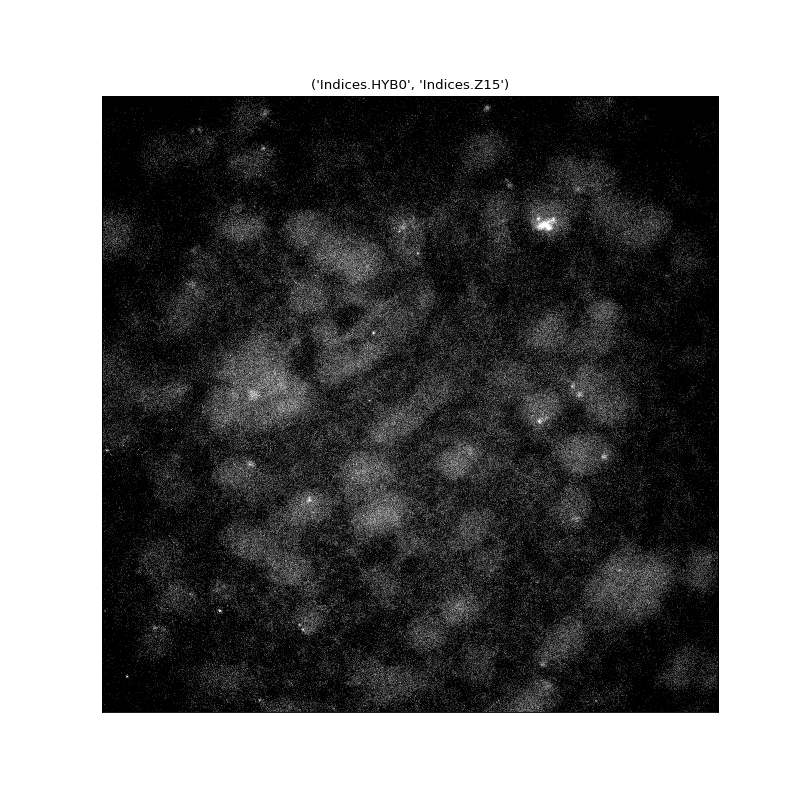

interactive(children=(IntSlider(value=16, description='plane_index', max=33), Output()), _dom_classes=('widget-interact',))

In [6]:
s.image.show_stack({Indices.CH: 0});

In [7]:
s_bandpass = Filter.Bandpass(lshort=0.5, llong=7, threshold=None, truncate=4, verbose=True)
s_bandpass.filter(s.image)

102it [00:34,  2.96it/s]


For bandpass, there's a point where things get weird, at `c == 0; z <= 14`. In that range the images look mostly like noise. However, _above_ that, they look great + background subtracted! The later stages of the pipeline appear robust to this, though, as no spots are called for the noisy sections. 

In [8]:
# I wasn't sure if this clipping was supposed to be by volume or tile. I've done tile here, but it can be easily
# switched to volume. 
s_clip = Filter.Clip(p_min=10, p_max=100, is_volume=False, verbose=True)
s_clip.filter(s.image)

102it [00:06, 14.82it/s]


In [9]:
sigma=(1, 0, 0)  # filter only in z, do nothing in x, y
glp = Filter.GaussianLowPass(sigma=sigma, is_volume=True, verbose=True)
glp.filter(s.image)

3it [00:27,  9.19s/it]


Below, because spot finding is so slow when single-plex, we'll pilot this on a max projection to show that the parameters work. Here's what trackpy.locate, which we wrap, produces for a z-projection of channel 1. To do use our plotting methods on z-projections we have to expose some of the starfish internals, which will be improved upon. 

In [10]:
from showit import image
from trackpy import locate

# grab a section from the tensor. 
ch1 = s.image.max_proj(Indices.Z)[0, 1]

results = locate(ch1, diameter=3, minmass=250, maxsize=3, separation=5, preprocess=False, percentile=10) 
results.columns = ['x', 'y', 'intensity', 'r', 'eccentricity', 'signal', 'raw_mass', 'ep']

In [23]:
# Renumber the indices to be range(len(results))
n_spots = len(results)
results.index = range(n_spots)
results.head()

,x,y,intensity,r,eccentricity,signal,raw_mass,ep
0,1.988506,249.063218,348.0,0.850963,0.349206,96.0,348.0,0.0
1,3.029915,505.940171,468.0,0.864791,0.342857,118.0,468.0,0.0
2,5.871747,213.871747,538.0,0.855770,0.395939,144.0,538.0,0.0
3,11.037471,461.011710,427.0,0.861620,0.413249,110.0,427.0,0.0
4,10.915663,1410.063253,332.0,0.872954,0.284585,79.0,332.0,0.0


<IPython.core.display.Javascript object>


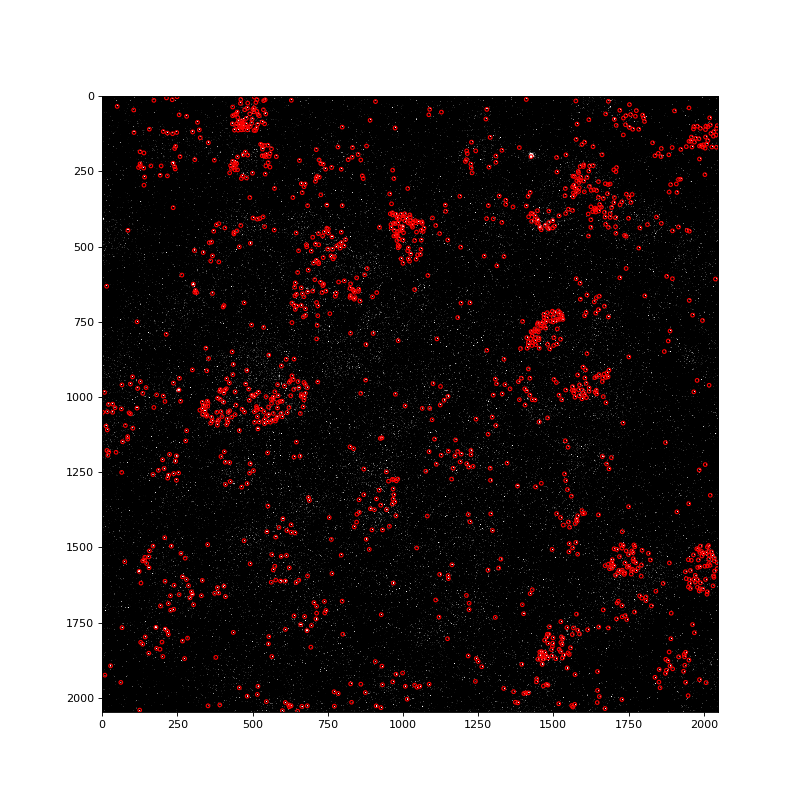

In [26]:
# plot the z-projection
f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ch1, vmin=15, vmax=52, cmap=plt.cm.gray)

# draw called spots on top as red circles
# scale radius plots the red circle at scale_radius * spot radius
s.image._show_spots(results, ax=ax, scale_radius=7);

Below spot finding is on the _volumes_ for each channel. This will take about `11m30s`

In [27]:
from starfish.pipeline.features.spots.detector import SpotFinder

# I've guessed at these parameters from the allen_smFISH code, but you might want to tweak these a bit. 
# as you can see, this function takes a while. It will be great to parallelize this. That's also coming, 
# although we haven't figured out where it fits in the priority list. 
kwargs = dict(
    spot_diameter=3, # must be odd integer
    min_mass=300,
    max_size=3,  # this is max _radius_
    separation=5,
    noise_size=0.65,  # this is not used because preprocess is False
    preprocess=False,
    percentile=10,  # this is irrelevant when min_mass, spot_diameter, and max_size are set properly
    verbose=True,
    is_volume=True,
)
lmpf = SpotFinder.LocalMaxPeakFinder(**kwargs)
spot_attributes = lmpf.find(s.image)

3it [10:05, 201.97s/it]


In [28]:
# save the results to disk as json
for attrs, (hyb, ch) in spot_attributes:
    attrs.save(f'spot_attributes_c{ch.value}.json')

In [17]:
# # if you want to load them back in the same shape, here's how:
# from starfish.pipeline.features.spot_attributes import SpotAttributes
# spot_attributes = [SpotAttributes.load(attrs) for attrs in glob('spot_attributes_c*.json')]

Clipping ...


<IPython.core.display.Javascript object>


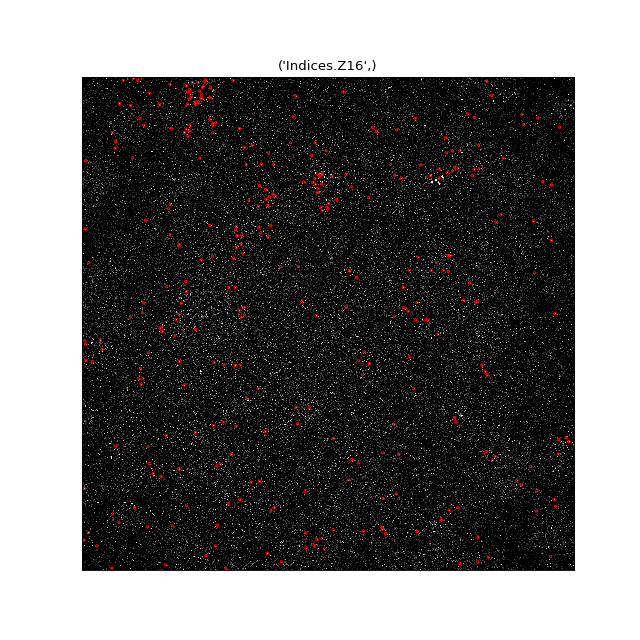

interactive(children=(IntSlider(value=16, description='plane_index', max=33), Output()), _dom_classes=('widget-interact',))

In [49]:
# this is not a very performant function because of how matplotlib renders circles as individual artists, 
# but I think it's useful for debugging the spot detection.

# Note that in places where spots are "missed" it is often because they've been localized to individual 
# nearby z-planes, whereas most spots exist across several layers of z.
results = spot_attributes[1][0].data
results.index = range(len(results))

s.image.show_stack({Indices.CH: 1, Indices.HYB: 0}, show_spots=results, figure_size=(8, 8), p_min=60, p_max=99.9);